In [1]:
#@title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
!pip install gin-config
!pip install pyproj
!pip install tensorflow
!pip install tqdm

In [3]:
#@title Imports

import abc
import dataclasses
import functools
import itertools
import enum
import math
import operator
from typing import Any, MutableMapping, Callable, Iterable, Mapping, Optional, Sequence, TypeVar, Union

from datetime import datetime
import gin
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import pyproj
import tensorflow as tf
import tqdm

In [4]:
SEED = 42

random.seed(SEED)

np.random.seed(SEED)

tf.random.set_seed(SEED)

In [5]:
gin.enter_interactive_mode()

# A UTM projection centered on south California.
# For details: https://epsg.io/26911-1750
SOUTH_CALIFORNIA_PROJECTION = pyproj.Proj(
'+proj=utm +zone=11 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 '
'+units=m +no_defs'
)

In [6]:
#@title A simple filter for catalogs

#@markdown Choosing earthquakes by location, time, magnitude.

# A type of method that takes a catalog and returns a boolean mask for
# earthquakes to keep.
EarthquakeCriterionType = Callable[[pd.DataFrame], np.ndarray]


def _is_in_rectangle(
    catalog: pd.DataFrame,
    longitude_range: tuple[float, float],
    latitude_range: tuple[float, float],
) -> np.ndarray:
  """Returns a mask indicating whether each earthquake is in a rectangle."""
  return (
      (catalog.longitude < longitude_range[1])
      & (catalog.longitude >= longitude_range[0])
      & (catalog.latitude < latitude_range[1])
      & (catalog.latitude >= latitude_range[0])
  )

@gin.configurable(denylist=['catalog'])
def earthquake_criterion(
    catalog: pd.DataFrame,
    longitude_range: tuple[float, float],
    latitude_range: tuple[float, float],
    start_timestamp: int,
    max_depth: float,
    min_magnitude: float,
) -> np.ndarray:
  """Returns a mask for earthquakes, according to common criteria.

  Args:
    catalog: The catalog of earthquakes.
    longitude_range: The range of the longitude (x) side of the rectangle in
      which earthquakes are kept.
    latitude_range: The range of the latitude (y) side of the rectangle in which
      earthquakes are kept.
    start_timestamp: Only keep earthquakes starting with this timestamp (seconds
      since  Epoch).
    max_depth: Maximal depth of earthquakes to keep.
    min_magnitude: Minimal magnitude of earthquakes to keep.

  Returns:
    A boolean numpy array, True where the corresponding earthquake in the
    catalog matches all of the criteria above.
  """
  return (
      (catalog.depth <= max_depth)
      & (catalog.magnitude >= min_magnitude)
      & (catalog.time >= start_timestamp)
      & _is_in_rectangle(catalog, longitude_range, latitude_range)
  )

In [7]:
#@title Dataclasses and types

# A container for a list of evaluation locations per an evaluation timestamp.
LocationsPerTime = MutableMapping[float, Sequence[tuple[float, float]]]


@gin.configurable
@dataclasses.dataclass(frozen=True)
class Rectangle:
  """Specifies a rectangle in latitutde-longitude coordinates."""
  min_lng: float
  max_lng: float
  min_lat: float
  max_lat: float


@dataclasses.dataclass(frozen=True)
class SampleSpaceTimes:
  """A set of evaluation locations for a given point in time."""

  history_time: float
  lead_time: float
  locations: Sequence[tuple[float, float]]

  @property
  def eval_time(self):
    """The time in the future, when we want to predict the rate."""
    return self.history_time + self.lead_time

  @classmethod
  def from_mapping(
      cls, locations_per_time: LocationsPerTime
  ) -> list['SampleSpaceTimes']:
    """Builds sample space times from an (old) mapping of times to locations."""
    all_times = np.array(sorted(locations_per_time))
    history_times, eval_times = all_times[:-1], all_times[1:]
    lead_times = eval_times - history_times
    all_locations = [locations_per_time[t] for t in eval_times]
    return [
        SampleSpaceTimes(history_time=t, lead_time=lead, locations=locations)
        for t, lead, locations in zip(history_times, lead_times, all_locations)
    ]


@dataclasses.dataclass(frozen=True)
class EvaluationSpaceTimes:
  """A container for the evaluation space-time pairs.

  Attributes:
    train_space_times: A mapping from train times (in seconds since Epoch) to
      corresponding locations (in UTM coordinates).
    validation_space_times: A mapping from validation times (in seconds since
      Epoch) to correspondinglocations (in UTM coordinates).
    test_space_times: A mapping from test times (in seconds since Epoch) to
      corresponding locations (in UTM coordinates).
    locations_per_time: The number of location per time. This is to highlight
      (and potentially verify) that the number is the same for every time.
    train_start: Timestamp (in seconds since Epoch) of the start of the training
      range.
    validation_start: Timestamp (in seconds since Epoch) of the start of the
      validation range (and the end of the training range).
    test_start: Timestamp (in seconds since Epoch) of the start of the test
      range (and the end of the validation range).
    test_end: Timestamp (in seconds since Epoch) of the end of the test range.
  """

  train_space_times: LocationsPerTime
  validation_space_times: LocationsPerTime
  test_space_times: LocationsPerTime
  locations_per_time: int
  train_start: float
  validation_start: float
  test_start: float
  test_end: float

  @classmethod
  @gin.configurable(denylist=['cls'])
  def init_with_earthquake_times_and_locations(
      cls,
      earthquake_criterion: EarthquakeCriterionType = earthquake_criterion,
      catalog: Optional[pd.DataFrame] = None,
      train_start: float = gin.REQUIRED,
      validation_start: float = gin.REQUIRED,
      test_start: float = gin.REQUIRED,
      test_end: float = gin.REQUIRED,
      longitude_range: tuple[float, float] = gin.REQUIRED,
      latitude_range: tuple[float, float] = gin.REQUIRED,
      grid_side_deg: float = gin.REQUIRED,
      projection: pyproj.Proj = SOUTH_CALIFORNIA_PROJECTION,
  ) -> 'EvaluationSpaceTimes':
    """Calculates evaluation space-times that match earthquakes in a catalog.

    The returned times and locations are such that for every time there is a
    regular grid of locations. If the time is of an earthquake, one of these
    locations will be the location of the earthquake. Otherwise, the locations
    will be shifted randomly.

    Args:
      earthquake_criterion: A function that accepts an earthquake catalog and
        returns a boolean index array of the same length, marking which
        earthquakes to keep.
      catalog: A dataframe of earthquakes. If None, the sample catalog is used.
        The catalog should be sorted by time.
      train_start: Timestamp (in seconds since Epoch) of the start of the
        training range.
      validation_start: Timestamp (in seconds since Epoch) of the start of the
        validation range.
      test_start: Timestamp (in seconds since Epoch) of the start of the test
        range.
      test_end: Timestamp (in seconds since Epoch) of the end of the test range.
      longitude_range: The range of the longitude (x) side of the rectangle in
        which earthquakes are kept. Allowed precision is up to 2 significant
        digits (~1 km).
      latitude_range: The range of the latitude (y) side of the rectangle in
        which earthquakes are kept. Allowed precision is up to 2 significant
        digits (~1 km).
      grid_side_deg: Per evaluation time add evenly spaced evaluation locations,
        with this grid size. Allowed precision is up to 2 significant digits (~1
        km).
      projection: Which projection to use (normally, from Lat/Lng to UTM).

    Returns:
      Evaluation space-times, that match the earthquakes in the (filtered)
      catalog. The right edge of every range (train, validation, test) is
      included as an evaluation time (with random locations).
    """
    if (
        np.round(grid_side_deg, 2) != grid_side_deg
        or np.round(longitude_range[0], 2) != longitude_range[0]
        or np.round(longitude_range[1], 2) != longitude_range[1]
        or np.round(latitude_range[0], 2) != latitude_range[0]
        or np.round(latitude_range[1], 2) != latitude_range[1]
    ):
      raise ValueError('The grid precision is up to 2 significant digits')
    if catalog is None:
      catalog = sample_catalog().sort_values('time')
    else:
      catalog = catalog.copy()
    catalog = catalog[earthquake_criterion(catalog)]

    split_edges = [
        (train_start, validation_start),
        (validation_start, test_start),
        (test_start, test_end),
    ]
    splits = [
        catalog[(catalog.time >= edges[0]) & (catalog.time < edges[1])]
        for edges in split_edges
    ]
    pairs = [
        dict(zip(df.time, zip(df.longitude, df.latitude))) for df in splits
    ]

    # Add the edge times.
    rs = np.random.RandomState(0)
    edge_times = [validation_start, test_start, test_end]
    random_lngs = rs.uniform(
        low=longitude_range[0], high=longitude_range[1], size=len(edge_times)
    )
    random_lats = rs.uniform(
        low=latitude_range[0], high=latitude_range[1], size=len(edge_times)
    )
    for i, edge in enumerate(edge_times):
      pairs[i][edge] = (random_lngs[i], random_lats[i])

    # Add locations on a grid for all times.
    n_locations = int(
        np.round(
            (longitude_range[1] - longitude_range[0])
            * (latitude_range[1] - latitude_range[0])
            / (grid_side_deg**2)
        )
    )
    all_space_times = []
    for part in pairs:
      # The data sets expect locations in UTM coordniates, while the evaluation
      # is done in Lat/Lng coordinates, to match external ETAS implementations.
      all_space_times.append({})
      for t, location in part.items():
        grid = _grid_locations(
            location, grid_side_deg, *longitude_range, *latitude_range
        )
        assert len(grid) == n_locations
        all_space_times[-1][t] = [
            projection(lng_lat[0], lng_lat[1]) for lng_lat in grid
        ]

    return EvaluationSpaceTimes(
        all_space_times[0],
        all_space_times[1],
        all_space_times[2],
        n_locations,
        train_start,
        validation_start,
        test_start,
        test_end,
    )


@dataclasses.dataclass(frozen=True)
class FeatureData:
  """Contains the features that are used for training and evaluating FERN.

  Class constants:
    DELIMETER: An indicative delimeter for filenames.

  Attributes:
    train_data: Features used for training. Keyed by the name of the dataset.
    validation_data: Features used for validation. Keyed by the name of the
      dataset.
    test_data: Features used for testing. Keyed by the name of the dataset.
  """

  train_data: dict[str, np.ndarray]
  validation_data: dict[str, np.ndarray]
  test_data: dict[str, np.ndarray]

  DELIMETER = '__'

  @gin.configurable
  def to_flat_partial(self, do_not_flatten: Sequence[str]) -> 'FeatureData':
    """Returns a flat version of the feature data.

    Args:
      do_not_flatten: A list of feature names that should not be completely
        flattened.

    Returns:
      New feature data, with flattened features. If the features are of shape
      (n_times, n_locations, x1, x2, ..., xn), the output features will have
      either shape (n_times * n_locations, x1*x2*...*x{n-1}, xn) - if they
      appear in the `do_not_flatten` list or shape
      (n_times * n_locations, x1*x2*...*xn) - otherwise.
    """
    new_train_data = {
        key: reshape_features_to_2d(data)
        for key, data in self.train_data.items()
    }
    new_validation_data = {
        key: reshape_features_to_2d(data)
        for key, data in self.validation_data.items()
    }
    new_test_data = {
        key: reshape_features_to_2d(data)
        for key, data in self.test_data.items()
    }
    for name in do_not_flatten:
      new_train_data[name] = reshape_features_to_3d(self.train_data[name])
      new_validation_data[name] = reshape_features_to_3d(
          self.validation_data[name]
      )
      new_test_data[name] = reshape_features_to_3d(self.test_data[name])
    return FeatureData(
        train_data=new_train_data,
        validation_data=new_validation_data,
        test_data=new_test_data,
    )

In [8]:
#@title Some utility functions

#@markdown 1. `earthquake_criterion` to get a subset of the catalog
#@markdown 2. `Rectangles` - a class to work with a grid of rectangles, while
#@markdown keeping track of the used projection
#@markdown 3. `StandardScaler` - A modification of sklearn's StandardScaler that
#@markdown allows to select axes


@dataclasses.dataclass(frozen=True)
class Rectangles:
  """A container for a list of a grid of rectangles, with useful methods.

  Attributes:
    rectangles: The list of rectangles.
    side_deg: The length of the side of the rectangles of the grid (in degrees).
    length: The number of rectangles in the grid.
  """
  rectangles: Sequence[Rectangle]
  side_deg: float
  length: int

  @classmethod
  @gin.configurable(denylist=['cls'])
  def init_grid(
      cls,
      longitude_range: tuple[float, float],
      latitude_range: tuple[float, float],
      side_deg: float,
  ) -> 'Rectangles':
    """Calculates evenly spaced rectangles.

    Args:
      longitude_range: The range of the longitude (x) side of the rectangle in
        which earthquakes are kept.
      latitude_range: The range of the latitude (y) side of the rectangle in
        which earthquakes are kept.
      side_deg: The length of the side of the rectangles of the grid in degrees.

    Returns:
      A list of rectangles for the requested grid.
    """
    if (
        np.round(side_deg, 2) != side_deg
        or np.round(longitude_range[0], 2) != longitude_range[0]
        or np.round(longitude_range[1], 2) != longitude_range[1]
        or np.round(latitude_range[0], 2) != latitude_range[0]
        or np.round(latitude_range[1], 2) != latitude_range[1]
    ):
      raise ValueError('The grid precision is up to 2 significant digits')

    int_side = int(np.round(side_deg * 100))
    int_lng_range = (
        int(np.round(longitude_range[0] * 100)),
        int(np.round(longitude_range[1] * 100)),
    )
    int_lat_range = (
        int(np.round(latitude_range[0] * 100)),
        int(np.round(latitude_range[1] * 100)),
    )

    min_lng_points = np.arange(*int_lng_range, int_side)
    min_lat_points = np.arange(*int_lat_range, int_side)

    rectangles = [
        Rectangle(
            lng / 100, (lng + int_side) / 100, lat / 100, (lat + int_side) / 100
        )
        for lng, lat in itertools.product(min_lng_points, min_lat_points)
    ]

    return Rectangles(rectangles, side_deg, len(rectangles))

  def index_of(
      self, location: tuple[float, float], projection: pyproj.Proj
  ) -> int:
    """Returns the index of the bin that contains the input location.

    Args:
      location: In UTM coordinates.
      projection: Which projection to use (normally, from Lat/Lng to UTM).

    Returns:
      The index of the bin that contains that location.
    """
    lng, lat = _utm_to_lng_lat(*location, projection)
    for i, rectangle in enumerate(self.rectangles):
      if rectangle.min_lng <= lng <= rectangle.max_lng:
        if rectangle.min_lat <= lat <= rectangle.max_lat:
          return i
    raise ValueError(
        f'Location {location} - ({lng}, {lat}) is not in any of the bins {self}'
    )


def _utm_to_lng_lat(
    x: float, y: float, projection: pyproj.Proj
) -> tuple[float, float]:
  """Converts UTM coordinates back to longitude and latitude."""
  lng, lat = projection(x, y, inverse=True)
  lng_deg, lat_deg = math.floor(lng), math.floor(lat)
  # Converting back to minutes, because then we can limit to the precision of
  # the catalog - 2 decimal points. This helps deal with points near the
  # boundary of rectangles.
  lng_minutes = np.round((lng - lng_deg) * 60, 2)
  lat_minutes = np.round((lat - lat_deg) * 60, 2)
  return lng_deg + lng_minutes / 60, lat_deg + lat_minutes / 60


@gin.configurable
def init_rectangles_grid(
    longitude_range: tuple[float, float],
    latitude_range: tuple[float, float],
    side_deg: float,
) -> Rectangles:
  """A thin wrapper around Rectangles.init_grid, for scoped binding."""
  return Rectangles.init_grid(longitude_range, latitude_range, side_deg)


def shift_locations_per_time(
    time_to_location: LocationsPerTime, new_time: float
) -> LocationsPerTime:
  """Creates a new time to locations mapping, that includes the new time.

  The new time must be before all times in the mapping.

  Args:
    time_to_location: A mapping from times to lists of locations.
    new_time: The new time to include in the mapping.

  Returns:
    A new mapping, that includes the new time, and excludes the most recent time
    in the original mapping. The locations are shifted by 1, from each timestamp
    to the timestamp that immediately precedes it in the original mapping (and
    the locations of the least recent time are shifted to the new time).
  """
  new_time_to_locations = {}
  times = np.sort(np.concatenate([[new_time], list(time_to_location.keys())]))
  assert times[0] == new_time
  for i in range(len(times) - 1):
    new, old = times[i], times[i + 1]
    new_time_to_locations[new] = time_to_location[old]
  return new_time_to_locations


def _grid_locations(
    location: tuple[float, float],
    grid_side: float,
    min_lng: float,
    max_lng: float,
    min_lat: float,
    max_lat: float,
) -> Sequence[tuple[float, float]]:
  """Returns an evenly spaced grid that starts at a given location."""
  # If the grid side is not an integer, the modulus can cause us to include the
  # wrong edge of the rectangle, due to floating point operation precision. We
  # fix this by limiting ourselves to 2 significant digits.
  int_grid_side = int(np.round(grid_side * 100))
  int_lng_range = (int(np.round(min_lng * 100)), int(np.round(max_lng * 100)))
  int_lat_range = (int(np.round(min_lat * 100)), int(np.round(max_lat * 100)))
  shift_lng = (location[0] * 100 - int_lng_range[0]) % int_grid_side
  shift_lat = (location[1] * 100 - int_lat_range[0]) % int_grid_side
  return list(
      itertools.product(
          (np.arange(*int_lng_range, int_grid_side) + shift_lng) / 100,
          (np.arange(*int_lat_range, int_grid_side) + shift_lat) / 100,
      )
  )


def reshape_features_to_2d(array: np.ndarray) -> np.ndarray:
  """Reshapes an n-dimensional feature array to 2 dimensions.

  Args:
    array: Input feature array, created by some data set; that is - it is
      assumed to have shape (n_times, n_locations, ...).

  Returns:
    A 2d version of the feature array, where the first axis corresponds to the
    index of the example, and the second axis corresponds to the index of the
    feature.
  """
  return array.reshape((array.shape[0] * array.shape[1], -1))


def reshape_features_to_3d(array: np.ndarray) -> np.ndarray:
  """Reshapes an n-dimensional array to 3 dimensions.

  Args:
    array: Input feature array, created by some data set; that is - it is
      assumed to have shape (n_times, n_locations, ..., n_features).

  Returns:
    A 3d version of the feature array, where the first axis corresponds to the
    index of the example, the second axis corresponds to the index of a setup,
    and the last axis corresponds to a feature function for that setup. This is
    a useful representation for RNNs and CNNs.
  """
  product = lambda arr: functools.reduce(operator.mul, arr, 1)
  return array.reshape(
      (product(array.shape[:2]), product(array.shape[2:-1]), array.shape[-1])
  )


class StandardScaler:
  """A modification of sklearn's StandardScaler that allows to select axes."""

  def __init__(self, feature_axes: Union[int, Sequence[int]] = 0):
    """Initializes a StandardScaler with 0 mean and standard deviation of 1.

    Args:
      feature_axes: int or tuple of ints. The axes over which mean and std are
        to be standardized. In the original scikit implementation this is 0.
    """
    self.mean = 0
    self.std = 1
    self.feature_axes = feature_axes

  def fit(self, x: np.ndarray):
    """Computes the mean and std to be used for later scaling."""
    self.mean = x.mean(axis=self.feature_axes, keepdims=True)
    self.std = x.std(axis=self.feature_axes, keepdims=True)

  def transform(self, x: np.ndarray) -> np.ndarray:
    """Performs standardization by centering and scaling."""
    return (x - self.mean) / self._handle_zeros_in_std()

  def fit_transform(self, x: np.ndarray) -> np.ndarray:
    """Performs both fit and transform on the input."""
    self.fit(x)
    return self.transform(x)

  def _handle_zeros_in_std(self) -> Union[float, np.ndarray]:
    """Handles case of zero std.

    Returns:
      Array/scalar of the same shape as `self.std`, with zeros replaced by ones.
    """
    if np.isscalar(self.std):
      if self.std == 0:
        return 1
      return self.std
    elif isinstance(self.std, np.ndarray):
      std = self.std.copy()
      std[std == 0.0] = 1.0
      return std
    raise ValueError('Unknown std type.')

In [9]:
#@title Architectures

#@markdown Some sample architecture implementations that can be passed to the
#@markdown encoders.

# A function that takes the name of the model, the size of the input, and any
# additional arguments, and returns a Keras model with the given input size.
ModelConstructor = Callable[[str, int], tf.keras.Model]

def _cnn_1d_layers(
    name: str,
    input_layer: tf.keras.layers.Layer,
    input_shape: Sequence[int],
    cnn_filters: Sequence[int],
    activation: str = 'relu',
    kernel_regularization: Optional[tf.keras.regularizers.Regularizer] = None,
) -> tf.keras.layers.Layer:
  """Applies a 1d CNN to an input, that represents a functions on the last axis.

  Assume that the input shape is (example, setups, feature), i.e. for every
  example (1st axis) there are several feature functions (3rd axis) that are
  calculated for different setups (2nd axis). For example `setups` can be one of
  the few past earthquakes, and `features` are functions that are calculated on
  each earthquake.
  This model starts with a few Conv layers, that are repeatedly applied to the
  entire last axis (thus, learning some combination of the features, that is
  shared between the different setups).

  Args:
    name: An identifier of the model.
    input_layer: The input layer.
    input_shape: The shape of the input layer. Expected to be 2-dimensional.
    cnn_filters: The number of filters per layer. The shape of every filter is
      equal to the number of filters in the previous layer (always taking the
      entire last axis).
    activation: The Keras activation function to use.
    kernel_regularization: Regularizer function.

  Returns:
    The output layer after the CNN layers are applied.
  """
  kernel_shape = (1, input_shape[-1])
  output_layer = tf.keras.layers.Reshape((*input_shape, 1))(input_layer)
  for i, n_filters in enumerate(cnn_filters):
    output_layer = tf.keras.layers.Conv2D(
        name=f'{name}_{i}_cnn',
        dtype='float64',
        filters=n_filters,
        kernel_size=kernel_shape,
        activation=activation,
        kernel_regularizer=kernel_regularization,
    )(output_layer)
    kernel_shape = (1, n_filters)
    # Swap the 'channels' axis to the last feature axis.
    output_layer = tf.keras.layers.Permute((1, 3, 2), dtype='float64')(
        output_layer
    )

  return output_layer


@gin.configurable
def order_invariant_cnn_model(
    name: str,
    input_shape: Sequence[int],
    cnn_filters: Sequence[int],
    activation: str = 'relu',
    kernel_regularization: Optional[tf.keras.regularizers.Regularizer] = None,
) -> tf.keras.Model:
  """Prepares a CNN model that represents a function on the set of examples.

  Args:
    name: An identifier of the model.
    input_shape: The shape of the input layer. Expected to be 2-dimensional.
    cnn_filters: The number of filters per layer. The shape of every filter is
      equal to the number of filters in the previous layer (always taking the
      entire last axis).
    activation: The Keras activation function to use.
    kernel_regularization: Regularizer function.

  Returns:
    A CNN followed by a sum (thus, being invariant to the order of examples).
  """
  input_layer = tf.keras.layers.Input(
      shape=input_shape, name=name, dtype='float64'
  )

  output_layer = _cnn_1d_layers(
      name,
      input_layer,
      input_shape,
      cnn_filters,
      activation,
      kernel_regularization,
  )

  output_layer = tf.keras.layers.Lambda(
      lambda x: tf.keras.backend.sum(x, axis=1)
  )(output_layer)
  output_layer = tf.keras.layers.Flatten()(output_layer)

  return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


@gin.configurable
def cnn_1d_model(
    name: str,
    input_shape: Sequence[int],
    cnn_filters: Sequence[int],
    dense_units: Sequence[int],
    activation: str = 'relu',
    kernel_regularization: Optional[tf.keras.regularizers.Regularizer] = None,
) -> tf.keras.Model:
  """Prepares a CNN model that represents a functions on the last axis.

  Args:
    name: An identifier of the model.
    input_shape: The shape of the input layer. Expected to be 2-dimensional.
    cnn_filters: The number of filters per layer. The shape of every filter is
      equal to the number of filters in the previous layer (always taking the
      entire last axis).
    dense_units: A list of sizes of the hidden and output layers.
    activation: The Keras activation function to use.
    kernel_regularization: Regularizer function.

  Returns:
    A CNN followed by a fully connected model.
  """
  input_layer = tf.keras.layers.Input(
      shape=input_shape, name=name, dtype='float64'
  )

  output_layer = _cnn_1d_layers(
      name,
      input_layer,
      input_shape,
      cnn_filters,
      activation,
      kernel_regularization,
  )

  output_layer = tf.keras.layers.Flatten()(output_layer)

  for i, units in enumerate(dense_units):
    output_layer = tf.keras.layers.Dense(
        units=units,
        name=f'{name}_{i}_dense',
        dtype='float64',
        activation=activation,
        kernel_regularizer=kernel_regularization,
    )(output_layer)
  return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


@gin.configurable
def fully_connected_model(
    name: str,
    input_size: int,
    layer_sizes: Sequence[int],
    activation: str = 'relu',
    kernel_regularization: Optional[tf.keras.regularizers.Regularizer] = None,
) -> tf.keras.Model:
  """Generates a keras model of stacked fully connected layers.

  Args:
    name: An identifier of the model.
    input_size: The number of units in the input layer.
    layer_sizes: A list of sizes of the hidden and output layers.
    activation: The Keras activation function to use.
    kernel_regularization: Regularizer function.

  Returns:
    A fully connecteed model.
  """
  input_layer = tf.keras.layers.Input(
      shape=(input_size,), name=name, dtype='float64'
  )
  output_layer = input_layer
  for i, layer_size in enumerate(layer_sizes):
    output_layer = tf.keras.layers.Dense(
        layer_size,
        kernel_initializer=tf.keras.initializers.glorot_normal(),
        kernel_regularizer=kernel_regularization,
        activation=activation,
        name=f'{name}_dense_{i}',
        dtype='float64',
    )(output_layer)
  return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


@gin.configurable
def identity_model(model_name: str, input_size: int) -> tf.keras.Model:
  """Prepares a model that just outputs the input."""
  return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(
          input_shape=(input_size,), name=model_name, dtype='float64'
      ),
  ])

In [10]:
#@title Targets

#@markdown Methods to get the "target" earthquakes, in some sense setting our
#@markdown labels.

@gin.configurable
def target_earthquakes(
    catalog: pd.DataFrame,
    earthquake_criterion: EarthquakeCriterionType = earthquake_criterion,
) -> pd.DataFrame:
  """Returns a catalog of earthquakes that we want to calculate hazards for.

  Args:
    catalog: A dataframe of earthquakes.
    earthquake_criterion: A function that accepts an earthquake catalog and
      returns a boolean index array of the same length, marking which
      earthquakes to keep.
  """
  catalog = catalog.copy()
  return catalog[earthquake_criterion(catalog)]


def earthquakes_mask_for_space_times(
    timestamp_to_locations: LocationsPerTime,
    tolerance_meters: float = 0.1,
    tolerance_seconds: float = 0.01,
) -> np.ndarray:
  """Calculates which space-times match target earthquakes.

  Args:
    timestamp_to_locations:  A mapping from times (in seconds since Epoch) to
      corresponding locations (in UTM coordinates), equal number of locations
      per timestamp.
    tolerance_meters: How near to an earthquake in the catalog the location must
      be, in both x and y coordinates.
    tolerance_seconds: How near to an earthquake in the catalog the location
      must be in the time coordinate.

  Returns:
    A binary array that indicates which space-time pairs are of earthquakes.
    The array has two dimensions - (time, location). The array is sorted in
    time.
  """
  catalog = target_earthquakes()
  n_locations = len(next(iter(timestamp_to_locations.values())))
  result = np.zeros((len(timestamp_to_locations), n_locations))

  assert np.all(np.diff(catalog.time.values) >= 0)

  timestamps = np.array(sorted(timestamp_to_locations))
  time_index_from = np.searchsorted(
      catalog.time.values, timestamps - tolerance_seconds, side='left'
  )
  time_index_to = np.searchsorted(
      catalog.time.values, timestamps + tolerance_seconds, side='right'
  )

  # In general they may be 2 earthquakes less than `tolerance_seconds` apart,
  # but it does not happen in our catalog. This assert will remind us to fix
  # this method if it will ever be the case.
  assert np.all(time_index_to - time_index_from) <= 1

  for i, timestamp in enumerate(timestamps):
    from_index, to_index = time_index_from[i], time_index_to[i]
    if from_index == to_index:
      continue
    x, y = catalog.x_utm.iloc[from_index], catalog.y_utm.iloc[from_index]
    for j, location in enumerate(timestamp_to_locations[timestamp]):
      if (
          abs(x - location[0]) <= tolerance_meters
          and abs(y - location[1]) <= tolerance_meters
      ):
        result[i, j] = 1
        break
  return result

In [11]:
#@title Data sets

"""Classes encapsulating different data sets used for FERN.

Every class here represents a different way to encode data for FERN.
Every class is responsible for the feature engineering of its data set.
Additionally, every class creates a keras model that encodes these features.
Downstream, FERN combines all of these models into one.

DeltaTimeDataSet and EarthquakesMaskDataSet are special data sets that are used
to construct the FERN model, and do not have their own encoding models.
All of the other data sets are optional.
"""


class DataSetType(enum.Enum):
  """Type of the data source."""
  DELTA_TIME = 1
  EARTHQUAKES_MASK = 2
  GREATEST_EARTHQUAKES = 3
  LOCATION = 4
  LOCATION_COORDINATES = 5
  RECENT_EARTHQUAKES = 6
  SEISMICITY_RATE = 7


# A type for functions that extract features from the catalog.
# The inputs are (1) the catalog, with n earthquakes, (2) a timestamp, (3) and
# (4) arrays of the x and y coordinates (respectively) of a list of m locations.
# The output is a 2d array of shape (m, n), holding the feature that corresponds
# to each location and earthquake.
CatalogFeature = Callable[
    [pd.DataFrame, int, np.ndarray, np.ndarray], np.ndarray
]

# A type for functions that extract features from seismicity rates.
# The inputs are (1) an array of shape (N, D), containing at index [i, j] the
# number of earthquakes with magnitude at least M in the L seconds before T at
# distance at most distances[j] from locations[i], (2) the D distances, (3) the
# magnitude M, (4) the lookback threshold D.
# The output is a 1d array of size N, holding the feature that corresponds to
# each location.
SeismicityRateFeature = Callable[
    [np.ndarray, np.ndarray, float, float], np.ndarray
]


def _repeat(array: np.ndarray, times: int) -> np.ndarray:
  """Repeats an input array along the 1st dimension."""
  return array.reshape(1, -1).repeat(times, axis=0)


def _distances(
    catalog: pd.DataFrame, x_coordinates: np.ndarray, y_coordinates: np.ndarray
) -> np.ndarray:
  """Calculates the distance between every earthquake and every coordinate."""
  return (
      np.subtract.outer(x_coordinates, catalog.x_utm.values) ** 2
      + np.subtract.outer(y_coordinates, catalog.y_utm.values) ** 2
  ) ** 0.5


DEFAULT_CATALOG_FUNCTIONS = (
    # 1 over the distance between earthquakes and evaluation locations.
    lambda df, t, xs, ys: 1 / (_distances(df, xs, ys) + 1e-3),
    # Log of the distance between earthquakes and evaluation locations.
    lambda df, t, xs, ys: np.log(_distances(df, xs, ys) + 1e-3),
    # Relative location of the earthquake.
    lambda df, t, xs, ys: np.subtract.outer(xs, df.x_utm.values),
    lambda df, t, xs, ys: np.subtract.outer(ys, df.y_utm.values),
    # The exponent of the magnitude of the earthquakes (a.k.a energy).
    lambda df, t, xs, ys: _repeat(np.exp(df.magnitude.values), xs.size),
    lambda df, t, xs, ys: _repeat(1 / np.exp(df.magnitude.values), xs.size),
    # The depth of the earthquakes.
    lambda df, t, xs, ys: _repeat(df.depth.values, xs.size),
    lambda df, t, xs, ys: _repeat((df.depth.values < 0).astype(int), xs.size),
    # The log of the time elapsed since each earthquake.
    lambda df, t, xs, ys: _repeat(np.log(np.maximum(t + 1e-3 - df.time.values, 1e-6)), xs.size),
    # 1 over the time elapsed since each earthquake.
    lambda df, t, xs, ys: _repeat(1 / (t + 1e-3 - df.time.values), xs.size),
)

DEFAULT_SEISMICITY_RATE_FUNCTIONS = (
    lambda n, distances, mag, lookback: n,
    lambda n, distances, mag, lookback: np.exp(mag),
    lambda n, distances, mag, lookback: 1 / np.exp(mag),
    lambda n, distances, mag, lookback: 1 / lookback,
    lambda n, distances, mag, lookback: np.log(lookback),
    lambda n, distances, mag, lookback: 1 / distances,
    lambda n, distances, mag, lookback: np.log(distances),
)


class BaseDataSet(abc.ABC):
  """Base class for datasets.

  Attributes:
    type: A unique identifier for the data set.
    name: A name for the dataset, to be used downstream by FERN.
    scaler: An instance of StandardScaler, used to normalize features. By
      default, when normalizing, we want the distribution of a feature over all
      timestamps and locations to be N(0, 1).
  """

  def __init__(self, dataset_type: DataSetType, name: str):
    """Initializes a BaseDataSet.

    Args:
      dataset_type: A unique identifier for the data set.
      name: A name for the dataset, to be used downstream by FERN.
    """
    self.type = dataset_type
    self.name = name
    self.scaler = StandardScaler(feature_axes=(0, 1))

  @abc.abstractmethod
  def prepare_features(
      self, space_times: LocationsPerTime
  ) -> np.ndarray:
    """Prepares the features of the dataset.

    Args:
      space_times: Times and locations at which to calculate the features. It is
        expected to have the same number of locations per timestamp. Note that
        some datasets may expect the timestamp to be after and some before the
        lead time (=delta_time).

    Returns:
      An n-dimensional array of features. The first dimension is the time
      dimension, i.e. the length of the first axis should be `len(space_times)`.
      The second dimension is the space dimension, i.e. the length of the second
      axis should be the length of any value in `space_times`.
      The features at index [i,j,:] will always be for the i-th timestamp, when
      the timestamps are sorted, and the j-th location in the order specified in
      `space_times[t]`.
    """

  @abc.abstractmethod
  def generate_model(self) -> tf.keras.Model:
    """Generates a dataset-specific keras model to be integrated in FERN."""


class DeltaTimeDataSet(BaseDataSet):
  """Data set with one feature: the lead time of the example."""

  def __init__(self, name: str = 'delta_time'):
    """Initializes the data set."""
    super().__init__(dataset_type=DataSetType.DELTA_TIME, name=name)

  def prepare_features(self, space_times: LocationsPerTime):
    """Prepares the features of the dataset.

    Args:
      space_times: Times and locations at which to calculate the features. Only
        uses the times.

    Returns:
      A 3-dimensional array of shape (len(space_times) - 1, len(locations), 1),
      (where 'locations' is the number of locations for every timestamp) holding
      the sizes of the time bins.
    """
    delta_time = np.diff(sorted(space_times.keys()))
    n_locations = len(next(iter(space_times.values())))
    assert np.all(delta_time > 0)
    return np.repeat(
        delta_time.reshape((len(space_times) - 1, 1, 1)), n_locations, axis=1
    )

  def generate_model(self) -> tf.keras.Model:
    """Prepares the keras model. In this case, it should not be used."""
    raise NotImplementedError(
        'This feature should never have an encoding model directly.'
    )


class EarthquakesMaskDataSet(BaseDataSet):
  """Data set that indicates whether the space-time bin has an earthquake."""

  def __init__(self, name: str = 'earthquakes_mask'):
    """Initializes the data set."""
    super().__init__(dataset_type=DataSetType.EARTHQUAKES_MASK, name=name)

  def prepare_features(self, space_times: LocationsPerTime):
    """Prepares the features of the dataset.

    Args:
      space_times: Times and locations at which to calculate the features. It is
        expected to have the same number of locations per timestamp. Expects the
        times to be after the lead time, so that the mask marks every space-time
        at the future (prediction) time, not at the past (history) time.

    Returns:
      A 3-dimensional array of shape (len(space_times), len(locations, 1)),
      (where 'locations' is the number of locations for every timestamp) holding
      an indicator whether the space-time has an earthquake.
    """
    mask = earthquakes_mask_for_space_times(space_times)
    return mask.reshape((mask.shape[0], mask.shape[1], 1))

  def generate_model(self) -> tf.keras.Model:
    """Prepares the keras model. In this case, it should not be used."""
    raise NotImplementedError(
        'This feature should never have an encoding model directly.'
    )


def _mock_earthquake(catalog: pd.DataFrame) -> pd.DataFrame:
  """Creates a tiny earthquake in the mean location of the catalog."""
  if len(catalog) == 0:
    return pd.DataFrame({
        'time': [0],
        'x_utm': [0],
        'y_utm': [0],
        'depth': [100],
        'magnitude': [-3],
    })
  return pd.DataFrame({
      'time': [catalog.time.min()],
      'x_utm': [catalog.x_utm.mean()],
      'y_utm': [catalog.y_utm.mean()],
      'depth': [catalog.depth.mean()],
      'magnitude': [-3],
  })


def _catalog_features_limited_earthquakes(
    catalog: pd.DataFrame,
    sort_by: str,
    space_times: LocationsPerTime,
    n_seconds: int,
    max_earthquakes: int,
    feature_functions: Sequence[CatalogFeature],
) -> np.ndarray:
  """Generates a raw feature numpy array for a limited number of earthquakes.

  Selects at most `max_earthquakes` in the past `n_seconds`, sorted by
  `sort_by`, and then calculates feature functions on the resulting entries.

  Args:
    catalog: Catalog of earthquakes.
    sort_by: Column name to sort earthquakes by, before choosing the top few.
      The sort is descending (so we take the most recent earthquakes if we sort
      by time, or the greatest magnitude earthquakes if we sort by magnitude).
    space_times: Times and locations at which to calculate the features. It is
      expected to have the same number of locations per timestamp.
    n_seconds: Number of seconds in the past to search for the earthquakes.
    max_earthquakes: Limit for the number of earthquakes to keep. If there are
      less than `max_earthquakes` in the time range, mock earthquakes with tiny
      magnitudes will be added.
    feature_functions: Functions for extracting features from the catalog.

  Returns:
    Numpy array of earthquake features. The first axis corresponds to
    timestamps, the second to locations, the third to an earthquake (sorted by
    `sort_by`, a total of `max_earthquakes`) and the fourth to
    `feature_functions`.
  """
  timestamps = np.array(sorted(space_times.keys()))
  n_locations = len(next(iter(space_times.values())))
  # For each evaluation time, find the index of the first earthquake after it,
  # and the index of the last earthquake that fits in the time range.
  first_earthquakes_indices = np.searchsorted(
      catalog.time, timestamps, side='right'
  )
  last_earthquake_indices = np.searchsorted(
      catalog.time, timestamps - n_seconds, side='left'
  )

  features = np.empty(
      (timestamps.size, n_locations, max_earthquakes, len(feature_functions))
  )
  for i, timestamp in enumerate(timestamps):
    first_earthquake_index = first_earthquakes_indices[i]
    last_earthquake_index = last_earthquake_indices[i]
    earthquake_indices = slice(last_earthquake_index, first_earthquake_index)
    sub_catalog = (
        catalog.iloc[earthquake_indices]
        .sort_values(sort_by, ascending=False)
        .head(max_earthquakes)
        .copy()
    )
    # Fill with default values, so that the length will always be the same.
    to_append = _mock_earthquake(sub_catalog)
    for _ in range(len(sub_catalog), max_earthquakes):
      sub_catalog = pd.concat([sub_catalog, to_append])

    xs = np.array([location[0] for location in space_times[timestamp]])
    ys = np.array([location[1] for location in space_times[timestamp]])
    for k, function in enumerate(feature_functions):
      features[i, :, :, k] = function(sub_catalog, timestamp, xs, ys)
  return features


class CatalogDataSet(BaseDataSet, abc.ABC):
  """Abstract data set based on the earthquakes catalog."""

  def __init__(
      self,
      dataset_type: DataSetType,
      name: str,
      earthquake_criterion: EarthquakeCriterionType = earthquake_criterion,
      catalog: Optional[pd.DataFrame] = gin.REQUIRED,
  ):
    """Initializes the data set.

    Args:
      dataset_type: A unique identifier for the data set.
      name: A name for the dataset, to be used downstream by FERN.
      earthquake_criterion: A function that accepts an earthquake catalog and
        returns a boolean index array of the same length, marking which
        earthquakes to keep.
      catalog: A dataframe of earthquakes. If None, the sample catalog is used.
        The catalog should be sorted by time.
    """
    super().__init__(dataset_type=dataset_type, name=name)

    self._catalog = catalog.copy()
    if self._catalog.time.diff().min() < 0:
      raise ValueError('Earthquake catalog should be sorted by time.')

    self._catalog = self._catalog[earthquake_criterion(self._catalog)]


@gin.configurable
class RecentEarthquakesDataSet(CatalogDataSet):
  """Data set containing data about the recent earthquakes, sorted by time."""

  def __init__(
      self,
      earthquake_criterion: EarthquakeCriterionType = earthquake_criterion,
      catalog: Optional[pd.DataFrame] = gin.REQUIRED,
      name: str = 'earthquakes',
  ):
    """Initializes the data set. See CatalogDataSet."""
    super().__init__(
        dataset_type=DataSetType.RECENT_EARTHQUAKES,
        name=name,
        earthquake_criterion=earthquake_criterion,
        catalog=catalog,
    )

    self.scaler = StandardScaler(feature_axes=(0, 1, 2))

  @gin.configurable(
      'RecentEarthquakesDataSet.prepare_features',
      allowlist=['n_seconds', 'max_earthquakes'],
  )
  def prepare_features(
      self,
      space_times: LocationsPerTime,
      n_seconds: int,
      max_earthquakes: int,
      feature_functions: Sequence[CatalogFeature] = DEFAULT_CATALOG_FUNCTIONS,
  ):
    """Generates a raw feature numpy array.

    Args:
      space_times: Times and locations at which to calculate the features. It is
        expected to have the same number of locations per timestamp.
      n_seconds: Number of seconds in the past to search for the past
        earthquakes.
      max_earthquakes: Limit for the number of earthquakes to keep. If there are
        less than `max_earthquakes` in the time range, mock earthquakes with
        tiny magnitudes will be added.
      feature_functions: Functions for extracting features from the catalog.

    Returns:
      Numpy array of earthquake features. The first axis corresponds to
      timestamps, the second to locations, the third to an earthquake (sorted by
      time, a total of `max_earthquakes`) and the fourth to `feature_functions`.
    """
    return _catalog_features_limited_earthquakes(
        self._catalog,
        'time',
        space_times,
        n_seconds,
        max_earthquakes,
        feature_functions,
    )

  @gin.configurable('RecentEarthquakesDataSet.generate_model')
  def generate_model(
      self,
      input_size: int,
      model_constructor: ModelConstructor = fully_connected_model,
  ) -> tf.keras.Model:
    """Generates a model with the model constructor, and given input size.

    Args:
      input_size: The number of features in the input.
      model_constructor: A method that creates a model.

    Returns:
      A model, provided by the model constructor.
    """
    return model_constructor(self.name, input_size)


def _num_in_square(
    square_xs_from: np.ndarray,
    square_ys_from: np.ndarray,
    square_xs_to: np.ndarray,
    square_ys_to: np.ndarray,
    x_coordinates: np.ndarray,
    y_coordinates: np.ndarray,
) -> np.ndarray:
  """Returns the number of coordinates in each of the input sqaures.

  The input coordinates for the squares are assumed to have shape
    (n_squares, n_distances).

  Args:
    square_xs_from: The left x coordinates of the of the squares.
    square_ys_from: The bottom y coordinates of the of the squares.
    square_xs_to: The right x coordinates of the of the squares.
    square_ys_to: The top y coordinates of the of the squares.
    x_coordinates: The x coordinates of the locations.
    y_coordinates: The y coordinates of the locations.

  Returns:
    A 2D array, where the [i,j]-th item holds the number of squares with the
    j-th side length that contain the i-th location.
  """
  return np.sum(
      np.greater_equal.outer(x_coordinates, square_xs_from)
      & np.less_equal.outer(x_coordinates, square_xs_to)
      & np.greater_equal.outer(y_coordinates, square_ys_from)
      & np.less_equal.outer(y_coordinates, square_ys_to),
      axis=1,
  )


@gin.configurable
class SeismicityRateDataSet(CatalogDataSet):
  """Data set containing the rates of earthquakes in the area."""

  def __init__(
      self,
      earthquake_criterion: EarthquakeCriterionType = earthquake_criterion,
      catalog: Optional[pd.DataFrame] = gin.REQUIRED,
      name: str = 'seismicity',
  ):
    """Initializes the data set. See CatalogDataSet."""
    super().__init__(
        dataset_type=DataSetType.SEISMICITY_RATE,
        name=name,
        earthquake_criterion=earthquake_criterion,
        catalog=catalog,
    )

    self.scaler = StandardScaler(feature_axes=(0, 1, 2, 3, 4))

  @gin.configurable(
      'SeismicityRateDataSet.prepare_features',
      allowlist=['magnitudes', 'square_sizes', 'lookback_seconds'],
  )
  def prepare_features(
      self,
      space_times: LocationsPerTime,
      magnitudes: Sequence[float] = gin.REQUIRED,
      square_sizes: Sequence[float] = gin.REQUIRED,
      lookback_seconds: Sequence[int] = gin.REQUIRED,
      feature_functions: Sequence[
          SeismicityRateFeature
      ] = DEFAULT_SEISMICITY_RATE_FUNCTIONS,
  ):
    """Generates a raw feature numpy array.

    Args:
      space_times: Times and locations at which to calculate the features. It is
        expected to have the same number of locations per timestamp.
      magnitudes: Magnitude thresholds to calculate seismicity.
      square_sizes: Bin sizes (in meters, centered in the location center) for
        calculation of seismicity rates.
      lookback_seconds: Time intervals (in the past from the evaluation times)
        for calculation of seismicity rates.
      feature_functions: Functions for feature engineering.

    Returns:
      Numpy array of earthquake features. The first axis corresponds to
      timestamps, the second to locations, the third to `magnitudes`, the
      fourth to `square_sizes`, the fifth to `lookback_seconds` and the last to
      `feature_functions`. For every timestamp T, location X, magnitude M,
      distance S and lookback D we calculate N - the number of earthquakes with
      magnitude at least M (in the filtered catalog) per second per km^2, in the
      D seconds before T at distance at most S from location X. The features are
      then calculated on the corresponding M, S, D, N.
    """
    timestamps = np.array(sorted(space_times.keys()))
    n_locations = len(next(iter(space_times.values())))
    features = np.zeros((
        len(space_times),
        n_locations,
        len(magnitudes),
        len(square_sizes),
        len(lookback_seconds),
        len(feature_functions),
    ))

    square_sizes = np.array(square_sizes)
    for magnitude_i, magnitude in enumerate(magnitudes):
      sub_catalog = self._catalog[self._catalog.magnitude >= magnitude]
      xs_from = np.subtract.outer(sub_catalog.x_utm.values, square_sizes / 2)
      ys_from = np.subtract.outer(sub_catalog.y_utm.values, square_sizes / 2)
      xs_to = np.add.outer(sub_catalog.x_utm.values, square_sizes / 2)
      ys_to = np.add.outer(sub_catalog.y_utm.values, square_sizes / 2)
      times_array = sub_catalog.time.values

      for timestamp_i, timestamp in enumerate(timestamps):
        loc_xs = np.array([location[0] for location in space_times[timestamp]])
        loc_ys = np.array([location[1] for location in space_times[timestamp]])
        last_index = np.searchsorted(times_array, timestamp, side='right')
        for lookback_i, lookback in enumerate(lookback_seconds):
          first_index = np.searchsorted(
              times_array, timestamp - lookback, side='left'
          )
          time_slice = slice(first_index, last_index)

          n_in_square = _num_in_square(
              xs_from[time_slice],
              ys_from[time_slice],
              xs_to[time_slice],
              ys_to[time_slice],
              loc_xs,
              loc_ys,
          )
          for feature_i, function in enumerate(feature_functions):
            features[timestamp_i, :, magnitude_i, :, lookback_i, feature_i] = (
                function(n_in_square, square_sizes, magnitude, lookback)
            )
    return features

  @gin.configurable('SeismicityRateDataSet.generate_model')
  def generate_model(
      self,
      input_size: int,
      model_constructor: ModelConstructor = fully_connected_model,
  ) -> tf.keras.Model:
    """Generates a model with the model constructor, and given input size.

    Args:
      input_size: The number of features in the input.
      model_constructor: A method that creates a model.

    Returns:
      A model, provided by the model constructor.
    """
    return model_constructor(self.name, input_size)


@gin.configurable
class LocationDataSet(BaseDataSet):
  """Data set with the location of the (bin of the) example.

  The location is encoded as a 1-hot encoding of all the available bins.
  """

  def __init__(
      self,
      projection: pyproj.Proj = SOUTH_CALIFORNIA_PROJECTION,
      name: str = 'current_location',
  ):
    """Initializes the data set."""
    super().__init__(dataset_type=DataSetType.LOCATION, name=name)

    self.projection = projection

  @gin.configurable('LocationDataSet.prepare_features')
  def prepare_features(
      self,
      space_times: LocationsPerTime,
      bins_constructor: Callable[[], Rectangles] = Rectangles.init_grid,
  ):
    """Prepares the features of the dataset.

    Args:
      space_times: Times and locations at which to calculate the features. It is
        expected to have the same number of locations per timestamp.
      bins_constructor: A division of the same space domain into bins. Provided
        as a constructor, for use with Gin.

    Returns:
      A 3 dimensional array of features. For every time and location, there is a
      1-hot encoding of which of the input bins contains the location.
    """
    timestamps = np.array(sorted(space_times.keys()))
    n_locations = len(next(iter(space_times.values())))
    bins = bins_constructor()
    features = np.zeros((timestamps.size, n_locations, bins.length))
    for timestamp_i, timestamp in enumerate(timestamps):
      for location_i, location in enumerate(space_times[timestamp]):
        features[
            timestamp_i, location_i, bins.index_of(location, self.projection)
        ] = 1
    return features

  @gin.configurable('LocationDataSet.generate_model')
  def generate_model(
      self,
      input_size: int,
      model_constructor: ModelConstructor = fully_connected_model,
  ) -> tf.keras.Model:
    """Generates a model with the model constructor, and given input size.

    Args:
      input_size: The number of features in the input.
      model_constructor: A method that creates a model.

    Returns:
      A model, provided by the model constructor.
    """
    return model_constructor(self.name, input_size)


@gin.configurable
class LocationCoordinatesDataSet(BaseDataSet):
  """Data set with two features: the location of the (bin of the) example."""

  def __init__(self, name: str = 'current_coordinates'):
    """Initializes the data set."""
    super().__init__(dataset_type=DataSetType.LOCATION_COORDINATES, name=name)

  def prepare_features(self, space_times: LocationsPerTime):
    """Prepares the features of the dataset."""
    timestamps = np.array(sorted(space_times.keys()))
    n_locations = len(next(iter(space_times.values())))
    features = np.zeros((timestamps.size, n_locations, 2))
    for timestamp_i, timestamp in enumerate(timestamps):
      for location_i, location in enumerate(space_times[timestamp]):
        features[timestamp_i, location_i, :] = location
    return features

  def generate_model(self) -> tf.keras.Model:
    """Prepares the keras model. In this case, it is the identity."""
    return identity_model(self.name, input_size=2)

In [12]:
#@title Data factory

#@markdown Here we combine different data sets into a single object. The main
#@markdown class is `DataFactory`. It handles the division of features into
#@markdown train, validation and test tests, for each data set.

FeaturesDict = dict[DataSetType, np.ndarray]

T = TypeVar('T')


class DataFactory:
  """Class that prepares feature data from individual datasets.

  Usage:
    factory = DataFactory([dataset1, dataset2, ...])
    factory.add_dataset(dataset3)
    data = factory.build(...)

  Attributes:
    datasets: A mapping between DataSetTypes and data sets. Each data set must
      inherit from BaseDataSet.
  """

  def __init__(self, datasets: Iterable[BaseDataSet]):
    """Initializes DataFactory from a list of datasets.

    Args:
      datasets: The datasets that will be used for feature extraction.
    """
    ids = [dataset.type for dataset in datasets]
    if len(ids) != len(set(ids)):
      raise ValueError('Duplicate datasets.')
    self.datasets = {dataset.type: dataset for dataset in datasets}

  def add_dataset(self, dataset: BaseDataSet):
    """Adds a dataset to the DataFactory."""
    if dataset.type in self.datasets:
      raise ValueError(f'A dataset of type {dataset.type} already exists.')
    self.datasets[dataset.type] = dataset

  def remove_dataset(self, dataset_type: DataSetType):
    """Removes a dataset from the DataFactory."""
    if dataset_type not in self.datasets:
      raise KeyError(f'There is no dataset with type {dataset_type}.')
    self.datasets.pop(dataset_type)

  @gin.configurable(denylist=['self', 'space_times'])
  def build_features(
      self,
      space_times: EvaluationSpaceTimes,
      prepare_features_args: Mapping[DataSetType, Mapping[str, Any]] = {},
      data_sets_to_normalize: Iterable[DataSetType] = tuple(),
      training: bool = True,
  ) -> FeatureData:
    """Prepares features for train and test splits.

    The features always include the delta_time and earthquake_mask datasets.
    The rest of the features are calculated up to the timestamp *before* the
    evaluation time. In a sense, the input timestamps are the "target" (or
    "label") times, and naturally we want to calculate the features before the
    lead time.
    Note that the time edges (e.g. train set start and end timestamps) are added
    to the evaluation.

    Args:
      space_times: Times and locations at which to calculate the features. It is
        expected to have the same number of locations per timestamp. Note that
        some datasets may expect the timestamp to be after and some before the
        lead time (=delta_time). This function expects the timestamps to be
        after the lead time (i.e. it should include the exact space-time of the
        target earthquake), and it will shift the timestamps to after the lead
        time where appropriate.
      prepare_features_args: Keyword arguments for the `prepare_features` method
        of every dataset, keyed by their types. Usually unused, since we pass
        arguments with Gin. But useful for tests nonetheless.
      data_sets_to_normalize: Types of features to normalize.
      training: Whether the function is being executed during training. If so,
        scalers will be fitted to the training set. Otherwise, the stored
        scalers will be used.

    Returns:
      A FeatureData object, containing training, validation, and testing data.
    """
    times_to_locations_dict = {
        'train': space_times.train_space_times,
        'valid': space_times.validation_space_times,
        'test': space_times.test_space_times,
    }
    left_edges = {
        'train': space_times.train_start,
        'valid': space_times.validation_start,
        'test': space_times.test_start,
    }

    features = {part: {} for part in times_to_locations_dict}

    # Prepare the two special datasets (delta_time and earthquake_mask).
    for part, time_to_location in times_to_locations_dict.items():
      # Earthquakes are marked after the lead time.
      mask = EarthquakesMaskDataSet().prepare_features(
          time_to_location
      )
      features[part][DataSetType.EARTHQUAKES_MASK] = mask[1:]

      # Delta time is calculated on times with the right edges. Locations are
      # ignored but their amounts are important.
      left_edge = left_edges[part]
      time_to_location[left_edge] = next(iter(time_to_location.values()))
      lead_time = DeltaTimeDataSet().prepare_features(
          time_to_location
      )
      features[part][DataSetType.DELTA_TIME] = lead_time
      _ = time_to_location.pop(left_edge)

      # Finally, the rest of the features are calculated before the lead time.
      shifted_time_to_location = shift_locations_per_time(
          time_to_location, left_edge
      )
      more_features = self._prepare_features(
          shifted_time_to_location, prepare_features_args
      )
      for data_set_type, features_per_data_set in more_features.items():
        features[part][data_set_type] = features_per_data_set

    features = self._normalize(features, data_sets_to_normalize, training)

    return FeatureData(
        train_data=self._id_key_to_name_key(features['train']),
        validation_data=self._id_key_to_name_key(features['valid']),
        test_data=self._id_key_to_name_key(features['test']),
    )

  @gin.configurable(denylist=['self', 'space_times'])
  def build_features_eval(
      self,
      space_times: Sequence[SampleSpaceTimes],
      data_sets_to_normalize: Iterable[DataSetType],
      do_not_flatten: Sequence[DataSetType],
      calculate_earthquakes_mask: bool = False,
  ) -> dict[str, np.ndarray]:
    """A version of the building features method, useful during evaluation.

    Args:
      space_times: Times and locations at which to calculate the features. It is
        expected to have the same number of locations per timestamp, and sorted
        by the history time.
      data_sets_to_normalize: Types of features to normalize.
      do_not_flatten: Types of feature types that should not be completely
        flattened.
      calculate_earthquakes_mask: Whether to calculate the earthquakes mask. It
        is slow to compute, and normally is not used during evaluation.

    Returns:
      A dictionary between data set names and the corresponding features.
    """
    # Technically, it's possible to extend this implementation to allow
    # repeating history and lead times. However, it isn't necessary right now,
    # and we can keep the implementation simpler.
    assert np.all(np.diff([x.history_time for x in space_times]) > 0)
    assert np.all(np.diff([x.eval_time for x in space_times]) > 0)

    features = {}

    history_to_locations = {x.history_time: x.locations for x in space_times}
    eval_to_locations = {x.eval_time: x.locations for x in space_times}
    lead_times = np.array([x.lead_time for x in space_times])
    n_locations = len(space_times[0].locations)

    if calculate_earthquakes_mask:
      features[DataSetType.EARTHQUAKES_MASK] = (
          EarthquakesMaskDataSet().prepare_features(eval_to_locations)
      )
    else:
      features[DataSetType.EARTHQUAKES_MASK] = np.zeros(
          (len(lead_times), n_locations, 1)
      )
    features[DataSetType.DELTA_TIME] = np.repeat(
        lead_times.reshape((-1, 1, 1)), n_locations, axis=1
    )

    for dataset_type, dataset in self.datasets.items():
      features[dataset_type] = dataset.prepare_features(history_to_locations)

    for dataset_type in data_sets_to_normalize:
      scaler = self.datasets[dataset_type].scaler
      features[dataset_type] = scaler.transform(features[dataset_type])

    for dataset_type, data in features.items():
      if dataset_type in do_not_flatten:
        features[dataset_type] = reshape_features_to_3d(data)
      else:
        features[dataset_type] = reshape_features_to_2d(data)

    return self._id_key_to_name_key(features)

  def build_models(
      self,
      generate_model_args: Mapping[DataSetType, Mapping[str, Any]],
  ) -> dict[str, tf.keras.Model]:
    """Prepares models for every data set.

    Args:
      generate_model_args: Keyword arguments for the `generate_model` method of
        every dataset, keyed by their types.

    Returns:
      A mapping between names of data sets and their models.
    """
    models = {}
    for dataset_type, dataset in self.datasets.items():
      models[dataset.name] = dataset.generate_model(
          **generate_model_args.get(dataset_type, {})
      )
    return models

  def _prepare_features(
      self,
      times_to_locations: LocationsPerTime,
      prepare_features_args: Mapping[DataSetType, Mapping[str, Any]],
  ) -> FeaturesDict:
    """Prepares features for all datasets on a set of evaluation times."""
    features = {}
    for dataset_type, dataset in self.datasets.items():
      features[dataset_type] = dataset.prepare_features(
          times_to_locations, **prepare_features_args.get(dataset_type, {})
      )
    return features

  def _normalize(
      self,
      features: dict[str, FeaturesDict],
      data_sets_to_normalize: Iterable[DataSetType],
      training: bool,
  ) -> dict[str, FeaturesDict]:
    """Normalizes the features."""
    for dataset_type in data_sets_to_normalize:
      scaler = self.datasets[dataset_type].scaler
      splits = ['train', 'valid', 'test']
      if training:
        features['train'][dataset_type] = scaler.fit_transform(
            features['train'][dataset_type]
        )
        splits = ['valid', 'test']
      for split in splits:
        features[split][dataset_type] = scaler.transform(
            features[split][dataset_type]
        )
    return features

  def _id_key_to_name_key(
      self, dictionary: dict[DataSetType, T]
  ) -> dict[str, T]:
    """Converts a dictionary keyed by dataset ids to be keyed by their names."""
    result = {}
    for dataset_type, value in dictionary.items():
      if dataset_type in self.datasets:
        result[self.datasets[dataset_type].name] = value
      # These are specified concretely, because (1) they should not be in the
      # list of datasets, and (2) they have a special wiring in the cumulative
      # hazard model architecture.
      elif dataset_type == DataSetType.EARTHQUAKES_MASK:
        result['earthquakes_mask'] = value
      elif dataset_type == DataSetType.DELTA_TIME:
        result['delta_time'] = value
    return result

In [13]:
#@title The FERN model

#@markdown The model is constructed as follows:
#@markdown
#@markdown There are different data sets (defined in the Data sets tab),
#@markdown representing different physical measurements - time, catalog of
#@markdown earthquakes, etc. Each such data set is represented as some array of
#@markdown features, and has a model for encoding these features. FERN combines
#@markdown these models into one, and attempts to learn all of their weights
#@markdown in order to optimize the standard ETAS loss.

_SECONDS_PER_DAY = 86400


@dataclasses.dataclass(frozen=True)
class CumulativeHazardOutput:
  """The different outputs of a cumulative hazard model.

  The attributes are 3 tensors of equal length, each matching the model's
  predicted values at time t, given data up to time t - dt.

  Attributes:
    hazard: The rate of occurrence of events at time t, as calculated by the
      model.
    cumulative_hazard: The integral of the hazard in the range [t - dt, t], as
      calculated by the model.
    earthquakes_mask: A binary mask that indicates whether an event occurred at
      time t.
  """
  hazard: tf.Tensor
  cumulative_hazard: tf.Tensor
  earthquakes_mask: tf.Tensor


def abs_glorot_uniform(shape, dtype: Optional[str] = None):
  """Glorot uniform weight initializer that only returns positive values."""
  return tf.keras.backend.abs(
      tf.keras.initializers.glorot_uniform(seed=None)(shape, dtype=dtype)
  )


def neg_glorot_uniform(shape, dtype: Optional[str] = None):
  """Glorot uniform weight initializer that only returns negative values."""
  return -abs_glorot_uniform(shape, dtype)


class NonNegativeFloat64(tf.keras.constraints.Constraint):
  """Constrains the weights to be non-negative."""

  def __call__(self, weights: tf.Tensor):
    return weights * tf.cast(tf.greater_equal(weights, 0), 'float64')


class NonPositiveFloat64(tf.keras.constraints.Constraint):
  """Constrains the weights to be non-positive."""

  def __call__(self, weights: tf.Tensor):
    return weights * tf.cast(tf.less_equal(weights, 0), 'float64')


def _non_negative_weights_layer(
    units: int,
    activation: Optional[str] = 'tanh',
    kernel_regularization: Optional[tf.keras.regularizers.Regularizer] = None,
) -> tf.keras.layers.Layer:
  """Returns a dense layer with only non-negative weights."""
  return tf.keras.layers.Dense(
      units,
      activation=activation,
      dtype='float64',
      kernel_initializer=abs_glorot_uniform,
      kernel_constraint=NonNegativeFloat64(),
      kernel_regularizer=kernel_regularization,
  )


def _non_positive_weights_layer(
    units: int,
    activation: Optional[str] = 'tanh',
    kernel_regularization: Optional[tf.keras.regularizers.Regularizer] = None,
) -> tf.keras.layers.Layer:
  """Returns a dense layer with only non-positive weights."""
  return tf.keras.layers.Dense(
      units,
      activation=activation,
      dtype='float64',
      kernel_initializer=neg_glorot_uniform,
      kernel_constraint=NonPositiveFloat64(),
      kernel_regularizer=kernel_regularization,
  )


def _all_positive_layers(
    layer_sizes: Sequence[int],
    delta_time: tf.keras.layers.Layer,
    combined_embedding: tf.keras.layers.Layer,
    kernel_regularization: Optional[tf.keras.regularizers.Regularizer],
) -> tf.keras.layers.Layer:
  """Adds only positive layers to two inputs layers."""
  # This combines delta_time and combined_embedding in one layer, where the
  # weights that are applied on delta_time are positive (for monotonicity).
  # Therefore, the activation (tanh) is performed manually below.
  delta_time = _non_negative_weights_layer(
      layer_sizes[0], None, kernel_regularization
  )(delta_time)
  cumulative_hazard = tf.keras.layers.Lambda(
      lambda inputs: tf.keras.backend.tanh(inputs[0] + inputs[1]),
      dtype='float64',
  )([delta_time, combined_embedding])

  for layer_size in layer_sizes[1:-1]:
    cumulative_hazard = _non_negative_weights_layer(
        layer_size, 'tanh', kernel_regularization
    )(cumulative_hazard)
  return _non_negative_weights_layer(
      layer_sizes[-1], 'softplus', kernel_regularization
  )(cumulative_hazard)


def _half_positive_layers(
    layer_size: int,
    delta_time: tf.keras.layers.Layer,
    combined_embedding: tf.keras.layers.Layer,
    kernel_regularization: Optional[tf.keras.regularizers.Regularizer],
) -> tf.keras.layers.Layer:
  """Adds a half-positive half-negative hidden layer."""
  # This combines delta_time and combined_embedding in one layer, where the
  # weights that are applied on delta_time are constructed so that the output is
  # monotonic in delta_time, and also can be concave (as a function of
  # delta_time).
  half_size = layer_size // 2
  second_half_size = layer_size - half_size

  delta_time_positive = _non_negative_weights_layer(
      half_size, None, kernel_regularization
  )(delta_time)
  delta_time_negative = _non_positive_weights_layer(
      second_half_size, None, kernel_regularization
  )(delta_time)

  # Split the combined embedding into two "layers", to combine separately with
  # the two parts of the delta_time encoding.
  combined_embedding_first = tf.keras.layers.Lambda(
      lambda x: tf.slice(x, (0, 0), (-1, half_size)), dtype='float64'
  )(combined_embedding)
  combined_embedding_second = tf.keras.layers.Lambda(
      lambda x: tf.slice(x, (0, half_size), (-1, second_half_size)),
      dtype='float64',
  )(combined_embedding)

  cumulative_hazard_first = tf.keras.layers.Lambda(
      lambda inputs: tf.keras.backend.tanh(inputs[0] + inputs[1]),
      dtype='float64',
  )([delta_time_positive, combined_embedding_first])
  cumulative_hazard_second = tf.keras.layers.Lambda(
      lambda inputs: tf.keras.backend.tanh(inputs[0] + inputs[1]),
      dtype='float64',
  )([delta_time_negative, combined_embedding_second])

  output_positive = _non_negative_weights_layer(1, None, kernel_regularization)(
      cumulative_hazard_first
  )
  output_negative = _non_positive_weights_layer(1, None, kernel_regularization)(
      cumulative_hazard_second
  )

  return tf.keras.layers.Lambda(
      lambda inputs: tf.keras.backend.softplus(inputs[0] + inputs[1]),
      dtype='float64',
  )([output_positive, output_negative])



def cumulative_hazard_inputs_order(input_names: Sequence[str]) -> Sequence[str]:
  """Returns a canonical order for inputs to the cumulative hazard model."""
  return sorted(input_names)


@gin.configurable(
    denylist=[
        'data_sets_models',
        'log_transform_delta_time',
        'delta_time_scaler',
    ]
)
def cumulative_hazard_model(
    data_sets_models: Mapping[str, tf.keras.Model],
    log_transform_delta_time: bool,
    delta_time_scaler: StandardScaler,
    layer_sizes: Sequence[int],
    kernel_regularization: Optional[tf.keras.regularizers.Regularizer] = None,
) -> tf.keras.Model:
  """Constructs a cumulative hazard FERN model.

  The output of this model is the cumulative hazard, and a binary mask which
  indicates whether the trained example represents an earthquake. It has the
  property that the partial derivative of the cumulative hazard with respect to
  the delta_time input is positive (this is the hazard).

  Args:
    data_sets_models: Models of the underlying data sets, keyed by human
      readable names.
    log_transform_delta_time: Whether to apply log on the delta_time input.
    delta_time_scaler: The scaler to apply to the delta_time input. If
      `log_transform_delta_time` is True, this scaler should have been fit to
      the log of delta_time.
    layer_sizes: A list of sizes of the hidden and output layers.
    kernel_regularization: Regularizer function.

  Returns:
    A cumulative hazard FERN model, and the order of the features that it
    expects to get.
  """
  delta_time_input = tf.keras.layers.Input(
      shape=(1,), name='delta_time', dtype='float64'
  )
  delta_time = delta_time_input
  mean, std = delta_time_scaler.mean, delta_time_scaler.std
  if log_transform_delta_time:
    delta_time = tf.keras.layers.Lambda(
        lambda dt: (tf.keras.backend.log(dt) - mean) / std
    )(delta_time)
  else:
    delta_time = tf.keras.layers.Lambda(lambda dt: (dt - mean) / std)(
        delta_time
    )

  combined_embedding = tf.keras.layers.concatenate(
      [model.output for model in data_sets_models.values()],
      name='concatenated_embeddings',
      dtype='float64',
  )
  combined_embedding = tf.keras.layers.Dense(
      layer_sizes[0],
      activation=None,
      dtype='float64',
      kernel_regularizer=kernel_regularization,
  )(combined_embedding)

  assert len(layer_sizes) >= 2
  assert layer_sizes[-1] == 1
  if len(layer_sizes) > 2:
    cumulative_hazard = _all_positive_layers(
        layer_sizes, delta_time, combined_embedding, kernel_regularization
    )
  else:
    cumulative_hazard = _half_positive_layers(
        layer_sizes[0], delta_time, combined_embedding, kernel_regularization
    )

  earthquakes_mask_input = tf.keras.layers.Input(
      shape=(1,), name='earthquakes_mask', dtype='float64'
  )

  #change
  earthquakes_mask_output = tf.keras.layers.Lambda(
      lambda x: x, name='mask_passthrough', dtype='float64'
  )(earthquakes_mask_input)

  inputs = [model.input for _, model in data_sets_models.items()] + [
      earthquakes_mask_input,
      delta_time_input,
  ]
  inputs_order = cumulative_hazard_inputs_order(
      [input.name for input in inputs]
  )
  inputs.sort(key=lambda input: inputs_order.index(input.name))

  return tf.keras.Model(
      inputs=inputs, outputs=[cumulative_hazard, earthquakes_mask_output]
  )

In [14]:
#@title Evaluation functions

def hazard_from_cumulative_hazard(
    cumulative_hazard: tf.Tensor,
    gradient_tape: tf.GradientTape,
    delta_time_tensor: tf.Tensor,
    space_bin_area: float,
) -> tf.Tensor:
  """Calculates the (properly scaled) hazard from a cumulative hazard model.

  Args:
    cumulative_hazard: The output of the model.
    gradient_tape: A tape that recorded the forward pass of the model.
    delta_time_tensor: A tensor containing the delta_time feature, expected to
      be in seconds.
    space_bin_area: The size of the space bin, expected to be in deg**2.

  Returns:
    The hazard, in [1/(day * deg**2)] units.
  """
  hazard = gradient_tape.gradient(cumulative_hazard, delta_time_tensor)
  # The gradient is taken with respect to delta_time in seconds, so we need to
  # rescale.
  hazard *= _SECONDS_PER_DAY
  # The output is the cumulative hazard per bin, so we need to rescale again.
  hazard /= space_bin_area
  return hazard


def get_model_output(
    model: tf.keras.Model,
    inputs_order: Sequence[str],
    batch_features: Mapping[str, np.ndarray],
    space_bin_area: float,
) -> CumulativeHazardOutput:
  """Calculates the outputs of a cumulative hazard model.

  Args:
    model: A cumulative hazard model (assumed to match the architecture above).
    inputs_order: The order of inputs expected by the model.
    batch_features: The features tensors, possibly batched.
    space_bin_area: The size of the space bin, expected to be in deg**2.

  Returns:
    The hazard values, the cumulative hazard values, and the earthquakes mask.
    The last two are direct outputs form the model, and the first one is
    calculated by backpropagation.
  """
  delta_time_index = inputs_order.index('delta_time')
  with tf.GradientTape() as tape:
    tensors = [
        tf.convert_to_tensor(batch_features[name], dtype=tf.float64)
        for name in inputs_order
    ]
    tape.watch(tensors[delta_time_index])
    cumulative_hazard_output, earthquakes_mask = model(tensors, training=False)

  hazard = hazard_from_cumulative_hazard(
      cumulative_hazard_output, tape, tensors[delta_time_index], space_bin_area
  )
  return CumulativeHazardOutput(
      hazard, cumulative_hazard_output, earthquakes_mask
  )

In [15]:
#@title The main training loop

# A history type, for tracking measurements during learning.
History = Mapping[str, Sequence[float]]


_BATCH_SIZE_FOR_LOSS = 100


@tf.function
def cumulative_hazard_loss(
    hazard: tf.Tensor, cumulative_hazard: tf.Tensor, earthquakes_mask: tf.Tensor
) -> float:
  """The ETAS log likelihood score, calculated given the cumulative hazard.

  Args:
    hazard: The rate of occurrence of events at time t, as calculated by the
      model.
    cumulative_hazard: The integral of the hazard in the range [t - dt, t], as
      calculated by the model.
    earthquakes_mask: A binary mask that indicates whether an event occurred at
      time t.

  Returns:
    The loss, which is the negative of the log likelihood score.
  """
  return tf.keras.backend.sum(
      cumulative_hazard - tf.math.log(1e-20 + hazard) * earthquakes_mask
  )


@gin.configurable
def build_factory(
    include_earthquakes_data: bool = True,
    include_seismicity_data: bool = True,
) -> DataFactory:
  """Builds a data factory with datasets determined by input flags.

  Args:
    include_earthquakes_data: Whether to use the RecentEarthquakesDataSet.
    include_seismicity_data: Whether to use the SeismicityRateDataSet.

  Returns:
    A data factory.
  """
  datasets = [LocationDataSet()]
  if include_earthquakes_data:
    datasets.append(RecentEarthquakesDataSet())
  if include_seismicity_data:
    datasets.append(SeismicityRateDataSet())
  return DataFactory(datasets)


def _dataset(
    features: Mapping[str, np.ndarray], inputs_order: Sequence[str]
) -> tf.data.Dataset:
  """Creates a tf.Dataset from a dictionary of features."""

  def _generator():
    n_examples = next(iter(features.values())).shape[0]
    for i in range(n_examples):
      yield tuple([features[name][i, :] for name in inputs_order])

  return tf.data.Dataset.from_generator(
      _generator,
      output_signature=tuple(
          [
              tf.TensorSpec(shape=features[name].shape[1:], dtype=tf.float64)
              for name in inputs_order
          ]
      ),
  )


class _TrainWrapper:
  """Wraps some training methods, in order to speed them up with tf.function."""

  def __init__(
      self,
      model: tf.keras.Model,
      learning_rate: float,
      learning_rate_decay: float,
      inputs_order: Sequence[str],
      space_bin_area: float,
  ):
    """Initializes the trainer.

    Args:
      model: The cumulative hazard model to train.
      learning_rate: The learning rate of the optimizer.
      learning_rate_decay: The multiplicative decay of the learning rate.
      inputs_order: The order of inputs expected by the model.
      space_bin_area: The size of the space bin, expected to be in deg**2.
    """
    self._model = model
    self._learning_rate = learning_rate
    self._learning_rate_decay = learning_rate_decay
    self._inputs_order = inputs_order
    self._delta_time_index = inputs_order.index('delta_time')
    self._space_bin_area = space_bin_area

    self._model.compile(optimizer=tf.keras.optimizers.Adam(self._learning_rate))

  @tf.function
  def _train_step(self, batch: tf.Tensor):
    """Trains one step, and applies the gradients."""
    with tf.GradientTape(persistent=True) as tape:
      tensors = [
          tf.convert_to_tensor(feature, dtype=tf.float64) for feature in batch
      ]
      for tensor in tensors:
        tape.watch(tensor)
      cumulative_hazard, earthquakes_mask = self._model(tensors, training=True)
      hazard = hazard_from_cumulative_hazard(
          cumulative_hazard,
          tape,
          tensors[self._delta_time_index],
          self._space_bin_area,
      )
      loss = cumulative_hazard_loss(
          hazard=hazard,
          cumulative_hazard=cumulative_hazard,
          earthquakes_mask=earthquakes_mask,
      )
      # Add regularization.
      loss += tf.keras.backend.sum(self._model.losses)

    gradients = tape.gradient(loss, self._model.trainable_weights)
    self._model.optimizer.apply_gradients(
        zip(gradients, self._model.trainable_weights)
    )

  @tf.function
  def _total_dataset_loss(self, dataset: tf.data.Dataset) -> float:
    """Calculates the total loss on the dataset."""
    total = np.float64(0)
    for batch in dataset:
      total += self._batch_loss(batch)
    return total

  @tf.function
  def _batch_loss(self, batch: tf.Tensor) -> float:
    """Calculates the total loss on one batch (fast, not for training)."""
    with tf.GradientTape() as tape:
      tensors = [
          tf.convert_to_tensor(feature, dtype=tf.float64) for feature in batch
      ]
      tape.watch(tensors[self._delta_time_index])
      cumulative_hazard, earthquakes_mask = self._model(tensors, training=False)
    hazard = hazard_from_cumulative_hazard(
        cumulative_hazard,
        tape,
        tensors[self._delta_time_index],
        self._space_bin_area,
    )
    return cumulative_hazard_loss(
        hazard=hazard,
        cumulative_hazard=cumulative_hazard,
        earthquakes_mask=earthquakes_mask,
    )

  def fit_model(
      self, feature_data: FeatureData, batch_size: int, epochs: int, log: bool,
  ) -> tuple[History, tf.keras.Model]:
    """Fits the model to the data.

    Args:
      feature_data: Features for training and validation, ordered as perscribed
        by the cumulative hazard model.
      batch_size: The size of the batch per training step.
      epochs: The number of epochs for training.
      log: Whether to display a progress bar when training.

    Returns:
      The history of the loss during training, and the trained model.
    """
    train_dataset = (
        _dataset(feature_data.train_data, self._inputs_order)
        .shuffle(buffer_size=10000)
        .batch(batch_size)
        .cache()
    )
    validation_dataset = (
        _dataset(feature_data.validation_data, self._inputs_order)
        .batch(batch_size)
        .cache()
    )
    test_dataset = (
        _dataset(feature_data.test_data, self._inputs_order)
        .batch(batch_size)
        .cache()
    )

    history = {'train_loss': [], 'validation_loss': [], 'test_loss': []}

    for _ in tqdm.tqdm(range(epochs), disable=not log):
      self._model.optimizer.learning_rate.assign(self._learning_rate)
      self._learning_rate *= self._learning_rate_decay
      for batch in train_dataset:
        self._train_step(batch)

      history['train_loss'].append(self._total_dataset_loss(train_dataset))
      history['validation_loss'].append(
          self._total_dataset_loss(validation_dataset)
      )
      history['test_loss'].append(self._total_dataset_loss(test_dataset))

    return history, self._model


@gin.configurable
def train_and_evaluate_cumulative_hazard(
    log_transform_delta_time: bool = True,
    space_bin_area: float = gin.REQUIRED,
    learning_rate: float = gin.REQUIRED,
    learning_rate_decay: float = gin.REQUIRED,
    batch_size: int = gin.REQUIRED,
    epochs: int = gin.REQUIRED,
    verbose: bool = False,
) -> tuple[History, tf.keras.Model]:
  """Trains a cumulative hazard FERN model.

  Arguments to the underlying classes and functions are passed with Gin,
  therefore most of them are not specified in this function.

  Args:
    log_transform_delta_time: Whether to apply log on the delta_time input.
    space_bin_area: The size of the space bin, expected to be in deg**2.
    learning_rate: The learning rate of the optimizer.
    learning_rate_decay: The multiplicative decay of the learning rate.
    batch_size: The size of the batch per training step.
    epochs: The number of epochs for training.
    verbose: Whether to display a progress bar when training.

  Returns:
    The history object, tracking metrics over epochs.
  """
  print('Creating features.')
  space_times = (
      EvaluationSpaceTimes.init_with_earthquake_times_and_locations(catalog=catalog)
  )
  factory = build_factory()
  features = factory.build_features(space_times=space_times).to_flat_partial()

  print('Creating a model.')
  dataset_models = factory.build_models(generate_model_args={})
  delta_time_scaler = StandardScaler(feature_axes=(0, 1))
  if log_transform_delta_time:
    delta_time_scaler.fit(np.log(features.train_data['delta_time']))
  else:
    delta_time_scaler.fit(features.train_data['delta_time'])
  model = cumulative_hazard_model(
      dataset_models, log_transform_delta_time, delta_time_scaler
  )

  print('Training the model.')
  inputs_order = cumulative_hazard_inputs_order(
      features.train_data.keys()
  )
  history, model = _TrainWrapper(
      model, learning_rate, learning_rate_decay, inputs_order, space_bin_area
  ).fit_model(features, batch_size, epochs, log=verbose)

  return history, model, factory

In [16]:
catalog = pd.read_csv('SCEDC_catalog.csv')
catalog.sort_values('time', inplace=True)
catalog.head()

,time,magnitude,depth,longitude,latitude,x_utm,y_utm
0,-1.199085e+09,2.73,6.0,-117.645,33.903,440367.549732,3.751588e+06
1,-1.198995e+09,3.00,6.0,-116.000,32.000,594457.463402,3.540873e+06
2,-1.198895e+09,2.00,6.0,-117.494,33.771,454257.899420,3.736875e+06
3,-1.198771e+09,2.00,6.0,-117.475,34.143,456208.233842,3.778114e+06
4,-1.198660e+09,3.00,6.0,-116.000,32.000,594457.463402,3.540873e+06


In [17]:
#@title Setting up the hyperparameters

# One advantage of Gin is the ability to view the entire configuration of the
# model in one location. We bind and explain some of the parameters below.
# Note that these values are for the toy catalog. In the actual model, for
# instance, we used a history of 80 and not 10 earthquakes, and the lookback
# times for the Seismicity Rate data set were on the order of months and years.

gin.clear_config()
tf.keras.backend.clear_session()

side_deg = 1
lng_range = (-130, -110)
lat_range = (30, 38)
target_depth = 100
# feature_magnitude = 3
target_magnitude = 4
# It is possible to bind a lower value for the feature magnitude (or any other
# parameter) with gin scoping.

# Train: 1985 - 2004
train_start_time = datetime(1985, 1, 1).timestamp()
# Validation: 2005 - 2013
validation_start_time = datetime(2005, 1, 1).timestamp()
# Test: 2014 - 2019
test_start_time = datetime(2014, 1, 1).timestamp()
test_end_time = datetime(2020, 1, 1).timestamp()

print(f"Training period: {datetime.fromtimestamp(train_start_time).date()} to {datetime.fromtimestamp(validation_start_time).date()}")
print(f"Validation period: {datetime.fromtimestamp(validation_start_time).date()} to {datetime.fromtimestamp(test_start_time).date()}")
print(f"Test period: {datetime.fromtimestamp(test_start_time).date()} to {datetime.fromtimestamp(test_end_time).date()}")

target_catalog = catalog[(catalog['magnitude'] >= target_magnitude)]

num_train_points = len(target_catalog[(target_catalog['time'] >= train_start_time) & (target_catalog['time'] < validation_start_time)])
num_val_points = len(target_catalog[(target_catalog['time'] >= validation_start_time) & (target_catalog['time'] < test_start_time)])
num_test_points = len(target_catalog[(target_catalog['time'] >= test_start_time) & (target_catalog['time'] < test_end_time)])

print("\nNumber of training points: ", num_train_points)
print("Number of validation points: ",num_val_points)
print("Number of test points: ",num_test_points)

# feature_catalog = catalog[catalog['magnitude'] >= feature_magnitude]

epochs = 30

with gin.unlock_config():

  # Take only earthquakes in our target rectangle, above the feature magnitude.
  gin.bind_parameter('earthquake_criterion.longitude_range', lng_range)
  gin.bind_parameter('earthquake_criterion.latitude_range', lat_range)
  gin.bind_parameter('earthquake_criterion.max_depth', target_depth)
  gin.bind_parameter('earthquake_criterion.min_magnitude', target_magnitude)
  gin.bind_parameter('earthquake_criterion.start_timestamp', train_start_time)

  # Train on a grid of locations in the target rectangle. Higher `grid_side_deg`
  # will lead to better approximations of the spatial integral in the loss
  # calculation, but increases the number of training examples - and therefore
  # the training time.
  gin.bind_parameter('init_with_earthquake_times_and_locations.train_start', train_start_time)
  gin.bind_parameter('init_with_earthquake_times_and_locations.validation_start', validation_start_time)
  gin.bind_parameter('init_with_earthquake_times_and_locations.test_start', test_start_time)
  gin.bind_parameter('init_with_earthquake_times_and_locations.test_end', test_end_time)
  gin.bind_parameter('init_with_earthquake_times_and_locations.longitude_range', lng_range)
  gin.bind_parameter('init_with_earthquake_times_and_locations.latitude_range', lat_range)
  gin.bind_parameter('init_with_earthquake_times_and_locations.grid_side_deg', side_deg)

  # Settings for data sets.
  # From our experiments, it helps to normalize the Recent Earthquakes data set.
  # The Seismicity Rate data set is already normalized in a sense (since it's a
  # rate for a given time range).
  gin.bind_parameter('build_features.data_sets_to_normalize', [DataSetType.RECENT_EARTHQUAKES])
  gin.bind_parameter('to_flat_partial.do_not_flatten', ['seismicity', 'earthquakes'])

  gin.bind_parameter('init_rectangles_grid.longitude_range', lng_range)
  gin.bind_parameter('init_rectangles_grid.latitude_range', lat_range)
  gin.bind_parameter('init_rectangles_grid.side_deg', side_deg)  # Note - doesn't actually have to be the same grid size
  gin.bind_parameter('LocationDataSet.prepare_features.bins_constructor', init_rectangles_grid)

  max_earthquakes = 10  # Used also to build the model, below
  gin.bind_parameter('RecentEarthquakesDataSet.prepare_features.max_earthquakes', max_earthquakes)
  gin.bind_parameter('RecentEarthquakesDataSet.prepare_features.n_seconds', 86400 * 30 * 2)

  magnitudes = (2, 3, 4) # Used also to build the model, below
  square_sizes = (1e3, 4e3, 16e3, 64e3, 256e3)  # In meters, because of the UTM projection
  lookback_seconds = (3600, 86400, 86400 * 7)
  gin.bind_parameter('SeismicityRateDataSet.prepare_features.magnitudes', magnitudes)
  gin.bind_parameter('SeismicityRateDataSet.prepare_features.square_sizes', square_sizes)
  gin.bind_parameter('SeismicityRateDataSet.prepare_features.lookback_seconds', lookback_seconds)

  # Settings for data set models construction.
  gin.bind_parameter('LocationDataSet.generate_model.input_size',
      int((lng_range[1] - lng_range[0]) * (lat_range[1] - lat_range[0]) / (side_deg ** 2)))
  gin.bind_parameter('fully_connected_model.layer_sizes', [16])
  gin.bind_parameter('fully_connected_model.activation', 'tanh')
  gin.bind_parameter('fully_connected_model.kernel_regularization', tf.keras.regularizers.l2(1e-4))
  gin.bind_parameter('LocationDataSet.generate_model.model_constructor', fully_connected_model)

  gin.bind_parameter('RecentEarthquakesDataSet.generate_model.input_size',
      (max_earthquakes, len(DEFAULT_CATALOG_FUNCTIONS)))
  gin.bind_parameter('order_invariant_cnn_model.cnn_filters', [16, 8])
  gin.bind_parameter('order_invariant_cnn_model.activation', 'tanh')
  gin.bind_parameter('order_invariant_cnn_model.kernel_regularization', tf.keras.regularizers.l2(1e-4))
  gin.bind_parameter('RecentEarthquakesDataSet.generate_model.model_constructor', order_invariant_cnn_model)

  gin.bind_parameter('SeismicityRateDataSet.generate_model.input_size',
      (len(magnitudes) * len(square_sizes) * len(lookback_seconds), len(DEFAULT_SEISMICITY_RATE_FUNCTIONS)))
  gin.bind_parameter('cnn_1d_model.cnn_filters', [16, 8])
  gin.bind_parameter('cnn_1d_model.dense_units', [16])
  gin.bind_parameter('cnn_1d_model.activation', 'tanh')
  gin.bind_parameter('cnn_1d_model.kernel_regularization', tf.keras.regularizers.l2(1e-4))
  gin.bind_parameter('SeismicityRateDataSet.generate_model.model_constructor', cnn_1d_model)

  # Settings for the construction of the head model.
  gin.bind_parameter('cumulative_hazard_model.layer_sizes', [64, 1])
  gin.bind_parameter('cumulative_hazard_model.kernel_regularization', tf.keras.regularizers.l2(1e-8))

  # Parameters for the main training loop. These are fairly standard
  # hyperparameters for a training loop.
  gin.bind_parameter('train_and_evaluate_cumulative_hazard.space_bin_area', side_deg ** 2)
  gin.bind_parameter('train_and_evaluate_cumulative_hazard.learning_rate', 3e-4)
  gin.bind_parameter('train_and_evaluate_cumulative_hazard.learning_rate_decay', 0.995)
  gin.bind_parameter('train_and_evaluate_cumulative_hazard.batch_size', 32)
  gin.bind_parameter('train_and_evaluate_cumulative_hazard.epochs', epochs)

Training period: 1985-01-01 to 2005-01-01
Validation period: 2005-01-01 to 2014-01-01
Test period: 2014-01-01 to 2020-01-01

Number of training points:  656
Number of validation points:  310
Number of test points:  170


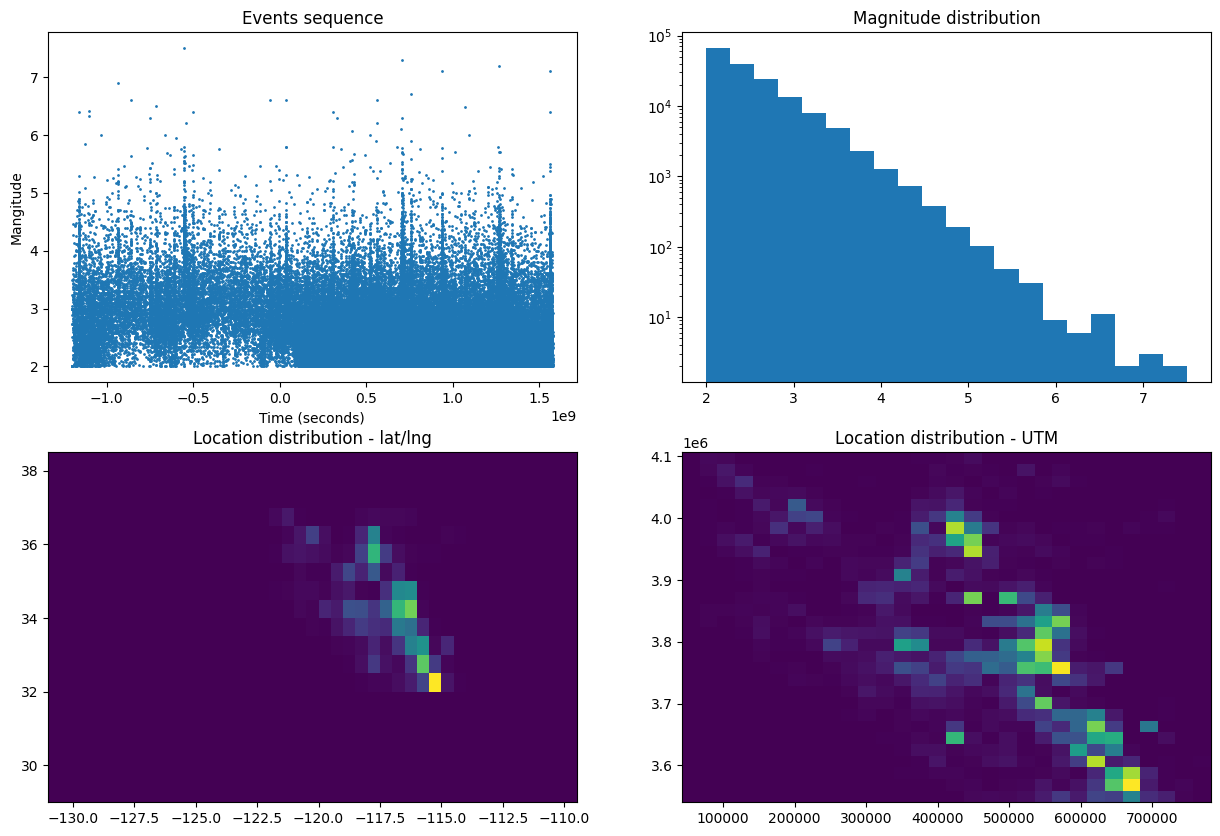

In [18]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
_ = axs[0][0].scatter(catalog.time, catalog.magnitude, s=1)
_ = axs[0][0].set_title('Events sequence')
_ = axs[0][0].set_xlabel('Time (seconds)')
_ = axs[0][0].set_ylabel('Mangitude')
_ = axs[0][1].hist(catalog.magnitude, bins=20, log=True)
_ = axs[0][1].set_title('Magnitude distribution')
_ = axs[1][0].hist2d(catalog.longitude, catalog.latitude,
                  bins=(np.arange(-131, -109, 0.5), np.arange(29, 39, 0.5)))
_ = axs[1][0].set_title('Location distribution - lat/lng')
_ = axs[1][1].hist2d(catalog.x_utm, catalog.y_utm, bins=30)
_ = axs[1][1].set_title('Location distribution - UTM')

In [19]:
#@title Train the model:

# Bind the catalog to the target (label) and data sets.

# NOTE: it is possible to use separate catalogs for the target and the data
# sets. For example, one may try to predict the rate of events above magnitude 4
# while using (in the data sets) all earthquakes above magnitude 2.

# The required catalog is a pandas DataFrame with the self-explanatory columns
# `time` (in seconds since Epoch time), `longitude`, `latitude`, `depth` [km],
# and `magnitude`. Additionally, add the columns `x_utm` and `y_utm` with an
# appropriate UTM projection of `longitude` and `latitude`.


with gin.unlock_config():
  gin.bind_parameter('target_earthquakes.catalog', target_catalog)
  gin.bind_parameter('RecentEarthquakesDataSet.catalog', target_catalog)
  gin.bind_parameter('SeismicityRateDataSet.catalog', target_catalog)

# The first epoch is usually much slower than the rest.
history, model, factory = train_and_evaluate_cumulative_hazard(verbose=True)

Creating features.
Creating a model.
Training the model.


100%|██████████| 30/30 [10:49<00:00, 21.66s/it]


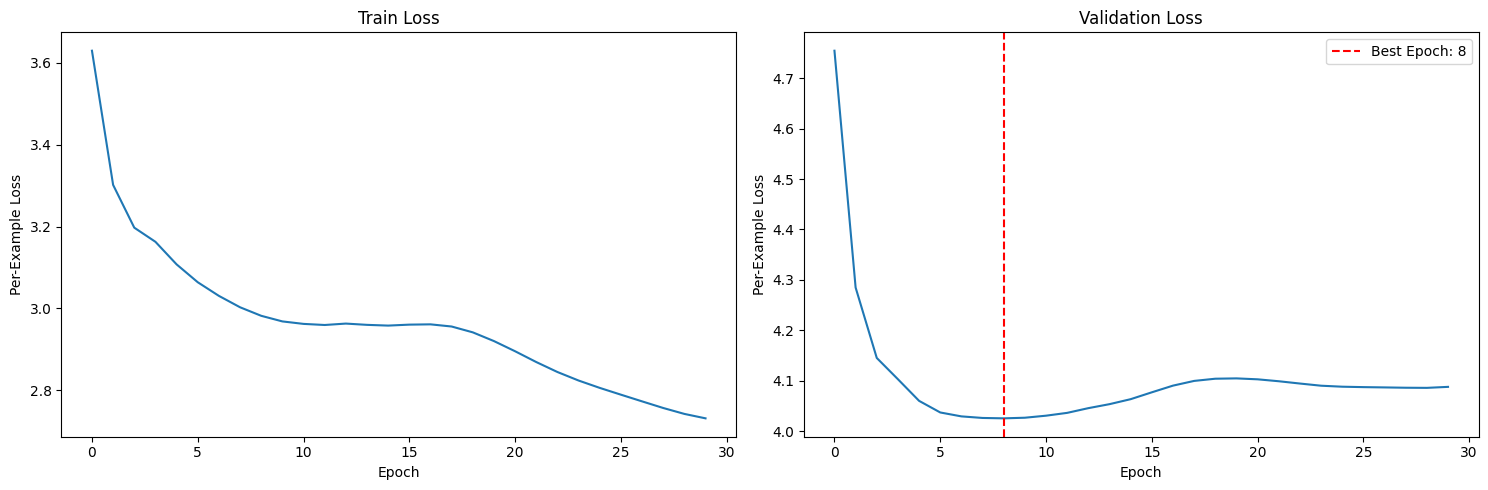


Lowest validation loss of 4.0255 occurred at epoch 8


In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

axs[0].plot(np.array(history['train_loss']) / num_train_points)
axs[0].set_title('Train Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Per-Example Loss')

validation_loss = np.array(history['validation_loss']) / num_val_points
axs[1].plot(validation_loss)
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Per-Example Loss')

best_epoch = np.argmin(validation_loss)
min_val_loss = validation_loss[best_epoch]

axs[1].axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch: {best_epoch}')
axs[1].legend()

plt.tight_layout()
plt.show()

print(f"\nLowest validation loss of {min_val_loss:.4f} occurred at epoch {best_epoch}")

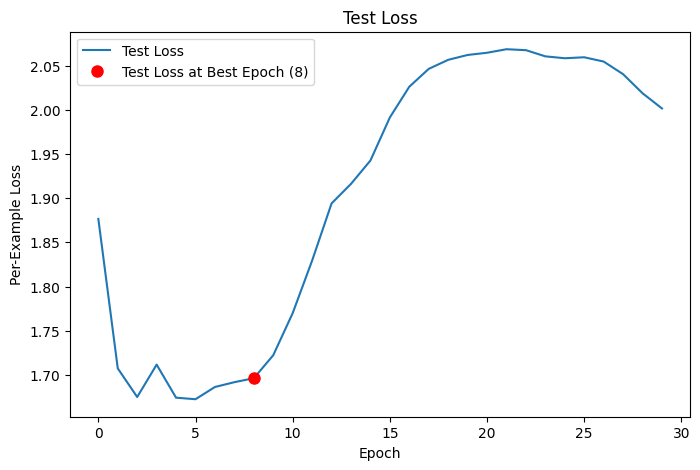


At the best epoch value of 8, the corresponding test loss is: 1.6961


In [21]:
fig, ax = plt.subplots(figsize=(8, 5))

test_loss = np.array(history['test_loss']) / num_test_points
ax.plot(test_loss, label='Test Loss')
ax.set_title('Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Per-Example Loss')

test_loss_at_best_epoch = test_loss[best_epoch]

ax.plot(best_epoch, test_loss_at_best_epoch, 'ro', markersize=8, label=f'Test Loss at Best Epoch ({best_epoch})')
ax.legend()

plt.show()

print(f"\nAt the best epoch value of {best_epoch}, the corresponding test loss is: {test_loss_at_best_epoch:.4f}")